In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torchvision.utils import save_image


In [3]:
#export
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
model_path = Path('seg_data/images')
path_clasif_images_train = 'ISIC_2019_Training_Input/'

In [5]:
learn = load_learner(model_path)

In [6]:
data = ImageList.from_folder('ISIC_2019_Training_Input/')

### Ejemplo

/home/mike/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


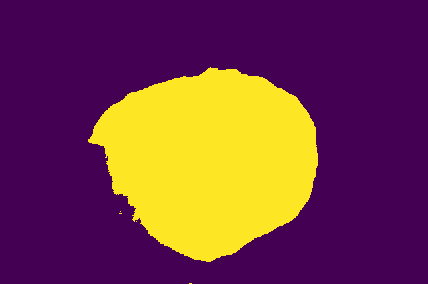

In [7]:
pred = learn.predict(data[0]); mask = pred[0].data; pred[0]

In [8]:
tfmd_img = data[0].apply_tfms([crop_pad()], size=(284,428), resize_method=ResizeMethod.CROP)

/home/mike/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


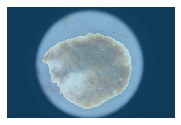

In [9]:
tfmd_img.show(y=pred[0])

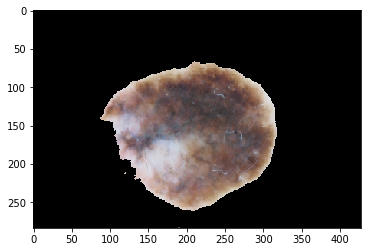

In [10]:
plt.imshow( (tfmd_img.data * mask).permute(1, 2, 0)  )


In [11]:
save_image(tfmd_img.data * mask, 'masked.jpg')

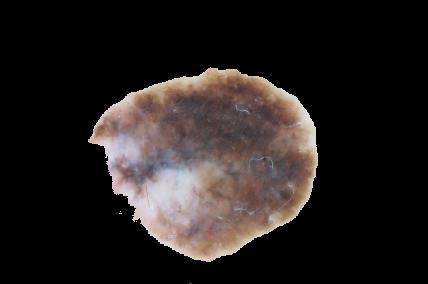

In [12]:
open_image('masked.jpg')

## Procesar todo

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [14]:
path_segmented_clasif_images_folder = Path('segmented_images')
n_of_images = len(data) 

In [15]:
for idx, an_image_to_segment in enumerate(data):
    pred = learn.predict(an_image_to_segment)
    mask = pred[0].data
    tfmd_img = an_image_to_segment.apply_tfms([crop_pad()], size=(284,428), resize_method=ResizeMethod.CROP)
    filename = data.items[idx]
    filepath = path_segmented_clasif_images_folder / filename
    save_image((tfmd_img.data * mask), filepath)
    update_progress(idx / n_of_images)

Progress: [####################] 100.0%


In [96]:
update_progress(0.5)

Progress: [##########----------] 50.0%
